In [1]:
%matplotlib inline
from utils import preprocess

In [2]:
import numpy as np
import pandas as pd
import os

In [3]:
from keras.models import Model
from keras.layers import Dense, Activation, Dropout
from keras.layers import Input

Using TensorFlow backend.


In [4]:
DATA_PATH = os.path.join('../data')
TRAIN_FILE = os.path.join(DATA_PATH, 'train.csv')
TEST_FILE = os.path.join(DATA_PATH, 'test.csv')

In [19]:
train_features = preprocess(TRAIN_FILE)
test_features = preprocess(TEST_FILE)

In [20]:
train_features = train_features[[u'vendor_id',
       u'passenger_count', u'trip_duration', u'pickup_hr', u'pickup_min', u'pickup_sec',
       u'pickup_day', u'pickup_date', u'pickup_mon', u'quarter',
       u'weekday', u'holiday', u'h_dist', u's_pickup_latitude',
       u's_pickup_longitude', u's_dropoff_latitude', u's_dropoff_longitude',
       u'flag', u'month_end', u'month_start']]

In [21]:
test_features = test_features[[u'vendor_id',
       u'passenger_count', u'pickup_hr', u'pickup_min', u'pickup_sec',
       u'pickup_day', u'pickup_date', u'pickup_mon', u'quarter',
       u'weekday', u'holiday', u'h_dist', u's_pickup_latitude',
       u's_pickup_longitude', u's_dropoff_latitude', u's_dropoff_longitude',
       u'flag', u'month_end', u'month_start']]

In [22]:
X_train = train_features[[u'vendor_id',
       u'passenger_count', u'pickup_hr', u'pickup_min', u'pickup_sec',
       u'pickup_day', u'pickup_date', u'pickup_mon', u'quarter',
       u'weekday', u'holiday', u'h_dist', u's_pickup_latitude',
       u's_pickup_longitude', u's_dropoff_latitude', u's_dropoff_longitude',
       u'flag', u'month_end', u'month_start']].as_matrix()
y_train = train_features['trip_duration']

In [23]:
X_test = test_features.as_matrix()

In [24]:
print X_train.shape
print y_train.shape
print X_test.shape

(1458644, 19)
(1458644,)
(625134, 19)


In [25]:
from keras.optimizers import Adam

In [27]:
from keras import backend as K
def root_mean_squared_logarithmic_error(y_true, y_pred):
    #y_pred = K.round(y_pred)
    first_log = K.log(K.clip(y_pred, K.epsilon(), None) + 1.)
    second_log = K.log(K.clip(y_true, K.epsilon(), None) + 1.)
    return K.sqrt(K.mean(K.square(first_log - second_log)))

rmsle = root_mean_squared_logarithmic_error

In [93]:
learning_rate = 0.0005

In [94]:
_input = Input(shape=(19,))
layer1 = Dense(50, activation='relu')(_input)
# layer2 = Dense(5, activation='relu')(layer1)
_output = Dense(1, activation='linear')(layer1)

model = Model(inputs=[_input], outputs=[_output])
optimizer = Adam(learning_rate)
model.compile(optimizer=optimizer,
             loss=rmsle)

In [95]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('weights.h5', save_best_only=True,
                             monitor='val_loss', verbose=0)
results = model.fit(X_train, y_train, 
                    batch_size=1024,
                    epochs=300, callbacks=[checkpoint],
                    validation_split=0.2)

Train on 1166915 samples, validate on 291729 samples
Epoch 1/300
1166915/1166915 [==============================] - 6s - loss: 1.7195 - val_loss: 0.9019
Epoch 2/300
1166915/1166915 [==============================] - 4s - loss: 0.8444 - val_loss: 0.8316
Epoch 3/300
1166915/1166915 [==============================] - 5s - loss: 0.8268 - val_loss: 0.8227
Epoch 4/300
1166915/1166915 [==============================] - 5s - loss: 0.8177 - val_loss: 0.8140
Epoch 5/300
1166915/1166915 [==============================] - 4s - loss: 0.8105 - val_loss: 0.8081
Epoch 6/300
1166915/1166915 [==============================] - 5s - loss: 0.8055 - val_loss: 0.8037
Epoch 7/300
1166915/1166915 [==============================] - 4s - loss: 0.8017 - val_loss: 0.8005
Epoch 8/300
1166915/1166915 [==============================] - 5s - loss: 0.7989 - val_loss: 0.7980
Epoch 9/300
1166915/1166915 [==============================] - 5s - loss: 0.7967 - val_loss: 0.7960
Epoch 10/300
1166915/1166915 [=================

1166915/1166915 [==============================] - 5s - loss: 0.7176 - val_loss: 0.7162
Epoch 82/300
1166915/1166915 [==============================] - 5s - loss: 0.7156 - val_loss: 0.7145
Epoch 83/300
1166915/1166915 [==============================] - 5s - loss: 0.7136 - val_loss: 0.7122
Epoch 84/300
1166915/1166915 [==============================] - 5s - loss: 0.7115 - val_loss: 0.7101
Epoch 85/300
1166915/1166915 [==============================] - 5s - loss: 0.7094 - val_loss: 0.7082
Epoch 86/300
1166915/1166915 [==============================] - 5s - loss: 0.7073 - val_loss: 0.7060
Epoch 87/300
1166915/1166915 [==============================] - 5s - loss: 0.7052 - val_loss: 0.7039
Epoch 88/300
1166915/1166915 [==============================] - 5s - loss: 0.7030 - val_loss: 0.7017
Epoch 89/300
1166915/1166915 [==============================] - 5s - loss: 0.7008 - val_loss: 0.7000
Epoch 90/300
1166915/1166915 [==============================] - 5s - loss: 0.6988 - val_loss: 0.6973
Epo

1166915/1166915 [==============================] - 5s - loss: 0.5652 - val_loss: 0.5649
Epoch 162/300
1166915/1166915 [==============================] - 5s - loss: 0.5638 - val_loss: 0.5623
Epoch 163/300
1166915/1166915 [==============================] - 5s - loss: 0.5626 - val_loss: 0.5609
Epoch 164/300
1166915/1166915 [==============================] - 5s - loss: 0.5611 - val_loss: 0.5597
Epoch 165/300
1166915/1166915 [==============================] - 5s - loss: 0.5601 - val_loss: 0.5585
Epoch 166/300
1166915/1166915 [==============================] - 5s - loss: 0.5588 - val_loss: 0.5570
Epoch 167/300
1166915/1166915 [==============================] - 5s - loss: 0.5575 - val_loss: 0.5568
Epoch 168/300
1166915/1166915 [==============================] - 5s - loss: 0.5564 - val_loss: 0.5548
Epoch 169/300
1166915/1166915 [==============================] - 5s - loss: 0.5555 - val_loss: 0.5558
Epoch 170/300
1166915/1166915 [==============================] - 5s - loss: 0.5541 - val_loss: 0

1166915/1166915 [==============================] - 5s - loss: 0.5144 - val_loss: 0.5131
Epoch 242/300
1166915/1166915 [==============================] - 5s - loss: 0.5146 - val_loss: 0.5133
Epoch 243/300
1166915/1166915 [==============================] - 5s - loss: 0.5143 - val_loss: 0.5130
Epoch 244/300
1166915/1166915 [==============================] - 5s - loss: 0.5141 - val_loss: 0.5128
Epoch 245/300
1166915/1166915 [==============================] - 5s - loss: 0.5147 - val_loss: 0.5157
Epoch 246/300
1166915/1166915 [==============================] - 5s - loss: 0.5141 - val_loss: 0.5143
Epoch 247/300
1166915/1166915 [==============================] - 5s - loss: 0.5144 - val_loss: 0.5133
Epoch 248/300
1166915/1166915 [==============================] - 5s - loss: 0.5141 - val_loss: 0.5138
Epoch 249/300
1166915/1166915 [==============================] - 5s - loss: 0.5141 - val_loss: 0.5126
Epoch 250/300
1166915/1166915 [==============================] - 5s - loss: 0.5137 - val_loss: 0

'\nresults = []\nfor lr, epochs in [(0.0005, 35), (0.0001, 50)]:\n    optimizer.lr.assign(lr)\n    result = model.fit(X_train, y_train, \n                    batch_size=1024,\n                    epochs=epochs, callbacks=[checkpoint],\n                    validation_split=0.2)\n    results.append(result)\n'

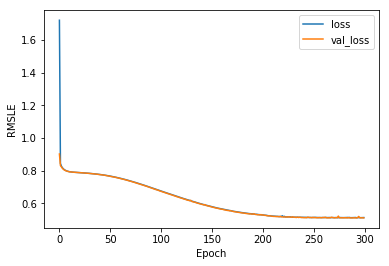

In [96]:
from matplotlib import pyplot as plt
plt.plot(results.epoch, results.history['loss'], label='loss')
plt.plot(results.epoch, results.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('RMSLE')
plt.legend()
plt.show()

In [100]:
test_features = preprocess(TEST_FILE)

In [101]:
test_features = test_features[[u'id', u'vendor_id',
       u'passenger_count', u'pickup_hr', u'pickup_min', u'pickup_sec',
       u'pickup_day', u'pickup_date', u'pickup_mon', u'quarter',
       u'weekday', u'holiday', u'h_dist', u's_pickup_latitude',
       u's_pickup_longitude', u's_dropoff_latitude', u's_dropoff_longitude',
       u'flag', u'month_end', u'month_start']]

In [102]:
model.load_weights('weights.h5')
with open('predictions.txt', 'w') as _file:
    _file.write('id,trip_duration\n')
    for example in test_features.as_matrix():
        tid, pred = example[0], model.predict(np.array([example[1:]]))
        pred = pred[0][0]
        _file.write('{},{}\n'.format(tid, pred))

In [103]:
!wc -l predictions.txt

  625135 predictions.txt


In [104]:
p = pd.read_csv('predictions.txt')

In [105]:
p.describe()

,trip_duration
count,625134.000000
mean,984.880062
std,815.253960
min,-151.395401
25%,577.211197
50%,738.557007
75%,1054.804626
max,163660.468750


In [107]:
z = pd.DataFrame(y_train)

In [108]:
z.describe()

,trip_duration
count,1.458644e+06
mean,9.594923e+02
std,5.237432e+03
min,1.000000e+00
25%,3.970000e+02
50%,6.620000e+02
75%,1.075000e+03
max,3.526282e+06
